# 3 Models and its validation

## 3.1 Impact of No-till on the change of SOC in the upper 30cm


### 3.1.1 Merging dataset

In [165]:
import pandas as pd
import numpy as np

from sklearn import linear_model
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OrdinalEncoder
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import Normalizer
from sklearn.preprocessing import StandardScaler
from scipy.stats import probplot
import seaborn as sns
import matplotlib.pyplot as plt
pd.set_option('display.max_columns',None)
pd.set_option('display.max_rows', None)

In [166]:
data_nums=pd.read_csv('df_nums_soc_mg.csv')
data_nums.drop(['Unnamed: 0'], axis=1, inplace=True)

In [167]:
data_cats=pd.read_csv('df_cats.csv')
data_cats.drop(['Unnamed: 0', 'id'], axis=1, inplace=True)

In [168]:
data_all= pd.concat([data_nums,data_cats], axis=1)
data_all.head()

,temp_c,precipitation_mm,depth_midpoint_previous,depth_midpoint_current,soc_g_kg_previous,soc_mg_ha_previous,latitud,longitud,elevation,slope,slopeclass,aspect,hillshade,rougness,cwd,pt10,avg_percipitation,bd_avg,ph_avg,cat_avg,clay_avg,slit_avg,sand_avg,gridsoc_g_kg_avg,soc_change_mg,change_till,fert_type
0,21.0,1500.0,5.0,5.0,48.393333,17.39,-21.35,-47.07,622.0,90.0,3.0,329.53,158.33,33.97,-320.33,45.65,261.0,1347.5,52.0,11.0,35.5,19.5,45.0,16.5,3.31,-1.0,NaN
1,21.0,1500.0,15.0,15.0,43.580000,15.57,-21.35,-47.07,622.0,90.0,3.0,329.53,158.33,33.97,-320.33,45.65,261.0,1347.5,52.0,11.0,35.5,19.5,45.0,16.5,-3.03,-1.0,NaN
2,21.0,1500.0,40.0,40.0,43.580000,55.38,-21.35,-47.07,622.0,90.0,3.0,329.53,158.33,33.97,-320.33,45.65,261.0,1347.5,52.0,11.0,35.5,19.5,45.0,16.5,-24.46,-1.0,NaN
3,21.0,1500.0,80.0,80.0,36.720000,36.10,-21.35,-47.07,622.0,90.0,3.0,329.53,158.33,33.97,-320.33,45.65,261.0,1347.5,52.0,11.0,35.5,19.5,45.0,16.5,0.13,-1.0,NaN
4,21.0,1500.0,5.0,5.0,48.393333,16.28,-21.35,-47.07,622.0,90.0,3.0,329.53,158.33,33.97,-320.33,45.65,261.0,1347.5,52.0,11.0,35.5,19.5,45.0,16.5,0.15,-1.0,NaN


In [169]:
data_top = data_all[data_all['depth_midpoint_current']<=30]
data_top.shape

(1114, 27)

### 3.1.2 Target distribution

data_top soc_change Mean: -0.4475583482944305
data_top soc_change_mg Median: 1.39
data_top soc_change_mg Max: 165.0
data_top soc_change_mg Skew: -5.049472884302139


/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


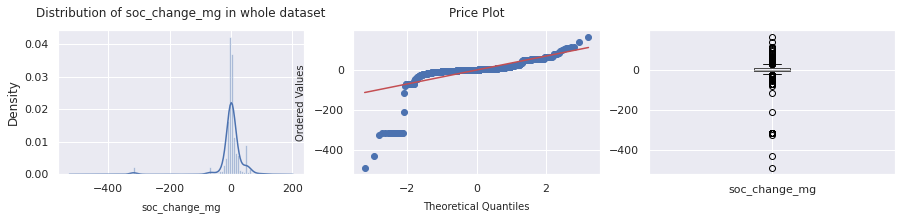

In [170]:
print('data_top soc_change Mean: {}'.format(data_top['soc_change_mg'].mean()))
print('data_top soc_change_mg Median: {}'.format(data_top['soc_change_mg'].median()))
print('data_top soc_change_mg Max: {}'.format(data_top['soc_change_mg'].max()))
print('data_top soc_change_mg Skew: {}'.format(data_top['soc_change_mg'].skew()))

fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize = (15,2))
plt.subplots_adjust(left=None, bottom=5, right=None, top=6, wspace=None, hspace=None)

sns.distplot(data_top['soc_change_mg'], hist=True, bins = 100, ax=ax1)
probplot(data_top['soc_change_mg'], plot=ax2)
data_top.boxplot('soc_change_mg', ax=ax3)

ax1.set_xlabel('soc_change_mg', size=10, labelpad=8)
ax2.set_xlabel('Theoretical Quantiles', size=10, labelpad=8)
ax2.set_ylabel('Ordered Values', size=10, labelpad=8)

ax1.set_title('Distribution of soc_change_mg in whole dataset', size=12, y=1.05)
ax2.set_title('Price Plot', size=12, y=1.05)

plt.show()

removing outliers

In [171]:
#data_top = data_top.drop(index=data_top[(data_top['soc_change_mg'] < -200)].index)

In [172]:
data_till_top = data_top.dropna(subset =['change_till'], axis=0)
data_till_top.shape

(720, 27)

In [173]:
data_tf_top = data_till_top.dropna(subset =['fert_type'], axis=0)
data_tf_top.shape

(185, 27)

In [174]:
data_fert_top = data_top.dropna(subset =['fert_type'], axis=0)
data_fert_top.shape

(388, 27)

preparing dataset

In [175]:
def display_missing(df):
    """shows the number of missing values of each column for a date_frame, if there is one"""
    for col in df.columns.tolist():
        if df[col].isnull().sum():
            print('{} column missing values: {}/{}'.format(col, df[col].isnull().sum(), len(df)))
    print ('Done checking for missing values')
display_missing(data_till_top)

fert_type column missing values: 535/720
Done checking for missing values


In [176]:
data_till_top=data_till_top.drop(['fert_type', 'depth_midpoint_previous', 'soc_g_kg_previous'], axis=1,)

In [177]:
data_till_top.shape

(720, 24)

In [178]:
display_missing(data_fert_top)

change_till column missing values: 203/388
Done checking for missing values


In [179]:
data_fert_top=data_fert_top.drop(['change_till', 'depth_midpoint_previous', 'soc_g_kg_previous'], axis=1)

In [180]:
data_fert_top.shape

(388, 24)

### 3.1.3 Model for no tillage, Linear Regression and Random Forest

In [181]:
y_till = data_till_top['soc_change_mg']
data_till_top = data_till_top.drop(['soc_change_mg'], axis=1)
data_till_top.shape

(720, 23)

In [182]:
X_num=data_till_top
transformer = StandardScaler().fit(X_num)
x_standardized = transformer.transform(X_num)
data_till_top_sc = pd.DataFrame(x_standardized)
data_till_top_sc.columns = X_num.columns
data_till_top_sc.head()

,temp_c,precipitation_mm,depth_midpoint_current,soc_mg_ha_previous,latitud,longitud,elevation,slope,slopeclass,aspect,hillshade,rougness,cwd,pt10,avg_percipitation,bd_avg,ph_avg,cat_avg,clay_avg,slit_avg,sand_avg,gridsoc_g_kg_avg,change_till
0,0.632063,0.454647,-1.373453,-0.452892,-1.301919,-0.622582,0.622359,0.482725,-0.095465,1.359841,1.4867,0.001462,-0.010855,-0.115881,1.25462,0.519338,-0.986877,-0.821885,1.083473,-0.750294,0.108363,-0.761258,-1.518079
1,0.632063,0.454647,0.025690,-0.470189,-1.301919,-0.622582,0.622359,0.482725,-0.095465,1.359841,1.4867,0.001462,-0.010855,-0.115881,1.25462,0.519338,-0.986877,-0.821885,1.083473,-0.750294,0.108363,-0.761258,-1.518079
2,0.632063,0.454647,-1.373453,-0.463442,-1.301919,-0.622582,0.622359,0.482725,-0.095465,1.359841,1.4867,0.001462,-0.010855,-0.115881,1.25462,0.519338,-0.986877,-0.821885,1.083473,-0.750294,0.108363,-0.761258,-1.518079
3,0.632063,0.454647,0.025690,-0.444624,-1.301919,-0.622582,0.622359,0.482725,-0.095465,1.359841,1.4867,0.001462,-0.010855,-0.115881,1.25462,0.519338,-0.986877,-0.821885,1.083473,-0.750294,0.108363,-0.761258,-1.518079
4,0.632063,0.454647,-1.373453,-0.489007,-1.301919,-0.622582,0.622359,0.482725,-0.095465,1.359841,1.4867,0.001462,-0.010855,-0.115881,1.25462,0.519338,-0.986877,-0.821885,1.083473,-0.750294,0.108363,-0.761258,-0.163659


In [183]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(data_till_top, y_till, test_size=0.3, random_state=1)

In [184]:
lm = linear_model.LinearRegression()
lr_1 = lm.fit(X_train,y_train)
predictions_1  = lm.predict(X_test)
r2_score(y_test, predictions_1)

0.46779436255343687

In [185]:
# Import the model we are using
from sklearn.ensemble import RandomForestRegressor
# Instantiate model with 1000 decision trees
rf_till = RandomForestRegressor(n_estimators = 1000, random_state = 1)
# Train the model on training data
rf_till.fit(X_train, y_train)
pred_rf_till = rf_till.predict(X_test)

# 4. Model Validation

In [186]:
import sklearn.metrics as metrics

def regression_results(dic_of_models, y_true):
    '''returns a dataframe with 'Model', 'expl_variance', 'r2', 'MAE', 'MSE', 'RMSE',
    need the dictionary of key='modelname', value=prediction, X_test, y_test as attributes'''
    model_val = pd.DataFrame(columns =['Model', 'expl_variance', 'r2', 'MAE', 'MSE', 'RMSE'])
    # Regression metrics
    for key, y_pred in dic_of_models.items():
        explained_variance=metrics.explained_variance_score(y_true, y_pred)
        mean_absolute_error=metrics.mean_absolute_error(y_true, y_pred) 
        mse=metrics.mean_squared_error(y_true, y_pred) 
        median_absolute_error=metrics.median_absolute_error(y_true, y_pred)
        r2=metrics.r2_score(y_true, y_pred)
        val_list = [key, 
                explained_variance,
                round(r2,4),
                round(mean_absolute_error,4),
                round(mse,4),
                round(np.sqrt(mse),4)]
        v_series = pd.Series(val_list, index = model_val.columns)
        model_val = model_val.append(v_series, ignore_index=True)
    return model_val

In [187]:
model_dic = {'lm_till': predictions_1,
             'randomforest_1_till' : pred_rf_till,
             }

In [188]:
regression_results(model_dic, y_test)

,Model,expl_variance,r2,MAE,MSE,RMSE
0,lm_till,0.468246,0.4678,29.5229,2391.4245,48.9022
1,randomforest_1_till,0.615606,0.6156,11.9737,1727.2634,41.5604


In [193]:
def plot_errors(y, y_pred):
    
    
 #   fig, (ax1, ax2) = plt.subplots(1, 2, figsize = (15,4))
  #  plt.subplots_adjust(left=None, bottom=5, right=None, top=6, wspace=None, hspace=None)
    fig, ax = plt.subplots()
    sns.set(color_codes=True)
    sns.set(rc={'figure.figsize':(10, 10)})
    plt.ylabel("Predicted SOC_change")
    plt.title("Test set: Predictions against real values")
    X_plot = np.linspace(-300, 50, 50)
    Y_plot = X_plot
    sns.regplot(x=y, y=y_pred, fit_reg=False, ax=ax,scatter_kws={"color": "blue", "s":5})
    plt.plot(X_plot, Y_plot, color='r',linewidth=4.)
    plt.show()
    
    sns.displot(y-y_pred, kde=True, ax=ax2)
    plt.title("Train set: Distribution of residuals")
    plt.show()

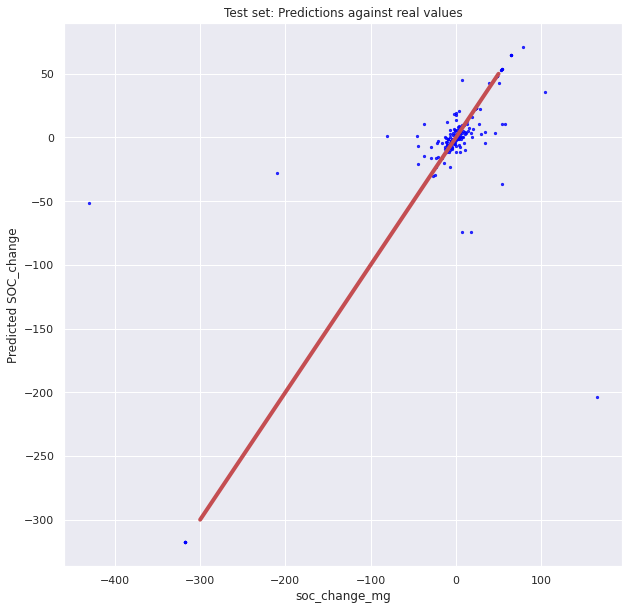

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2164: UserWarning: `displot` is a figure-level function and does not accept the ax= paramter. You may wish to try histplot.
  warnings.warn(msg, UserWarning)


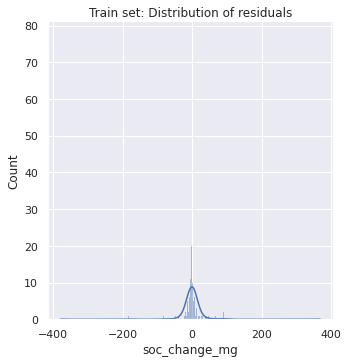

In [194]:
plot_errors(y_test, pred_rf_till )

In [196]:
import statsmodels.api as sm

ols=sm.add_constant(X_train)
mod = sm.OLS(y_train, ols)
res = mod.fit()

print(res.summary())

                            OLS Regression Results                            
Dep. Variable:          soc_change_mg   R-squared:                       0.521
Model:                            OLS   Adj. R-squared:                  0.499
Method:                 Least Squares   F-statistic:                     23.82
Date:                Wed, 10 Mar 2021   Prob (F-statistic):           3.74e-63
Time:                        22:28:46   Log-Likelihood:                -2517.0
No. Observations:                 504   AIC:                             5080.
Df Residuals:                     481   BIC:                             5177.
Df Model:                          22                                         
Covariance Type:            nonrobust                                         
                             coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------
const                      0

Feature: 0, Score: 0.01382
Feature: 1, Score: 0.37890
Feature: 2, Score: 0.03590
Feature: 3, Score: 0.21177
Feature: 4, Score: 0.02282
Feature: 5, Score: 0.01547
Feature: 6, Score: 0.01989
Feature: 7, Score: 0.01259
Feature: 8, Score: 0.00931
Feature: 9, Score: 0.00870
Feature: 10, Score: 0.00737
Feature: 11, Score: 0.01841
Feature: 12, Score: 0.02997
Feature: 13, Score: 0.06809
Feature: 14, Score: 0.02840
Feature: 15, Score: 0.01574
Feature: 16, Score: 0.01233
Feature: 17, Score: 0.01671
Feature: 18, Score: 0.02785
Feature: 19, Score: 0.00888
Feature: 20, Score: 0.01367
Feature: 21, Score: 0.02103
Feature: 22, Score: 0.00238


/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


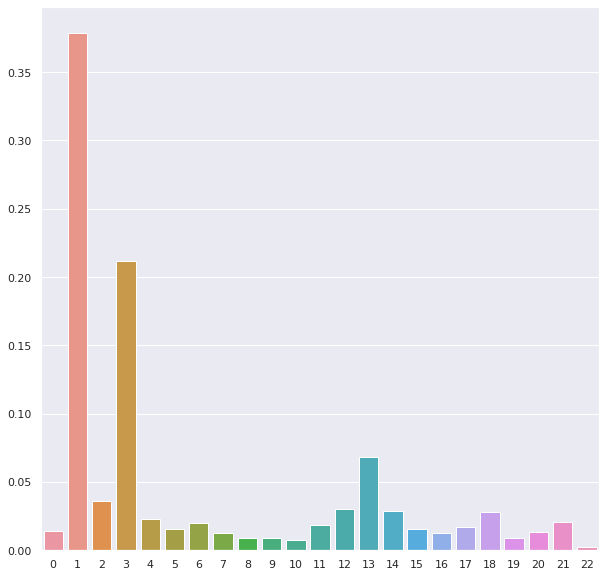

In [198]:
importance = rf_till.feature_importances_
# summarize feature importance
for i,v in enumerate(importance):
	print('Feature: %0d, Score: %.5f' % (i,v))
# plot feature importance
sns.barplot([x for x in range(len(importance))], importance)